### Importing the Necessary library

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import matplotlib.pyplot as plt
from PIL import Image
from io import open
from torchvision import datasets, transforms
from PIL import Image
import cv2
import csv
import pandas as pd
from torch import optim
import torchvision.models as models
import shutil
from PIL import Image, ImageDraw

### Loading the Model
Before loading the model, the model's architecture need to be initialize and created

In [3]:
'''
Initializing CNN Architecture:
    - 3 Convolutional Layers
    - 3 Pooling Layers
    - 2 Fully Connected Layers
This model takes an image of 224x224 pixel with 3 RGB values
'''
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)          
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 7)
    
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)      

In [4]:
'''
Loading the saved model file and loading the state of the model with the architecture. Make sure to set the 
model to evaluation mode with the code "model.eval()"
'''
model_path = 'intel_dataset_98acc_79t.model'
model = CNN()
model.load_state_dict(torch.load(model_path))
model.eval()

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
)

# Inference Script 
- Use Pie Chart if the folder is known to have a majority Class Label (Eg: Testing an unseen image of 300 buildings) <br /> <br />
- Use Bar Plot if the class is mixed up (eg: Testing an image that has the mixture of all 6 classes)

### inference test 3 - WITHOUT Mask<br>
- Renaming output_folder, extension for image only, put everyone in output_folder <br> 
- Without Masking

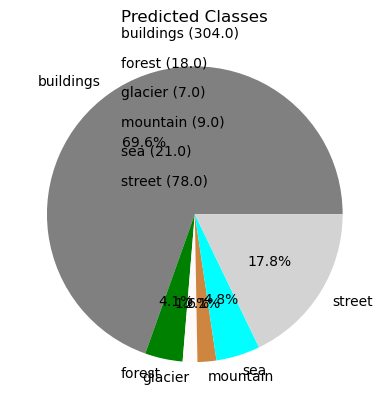

In [6]:
'''
                                            PIE CHART 
- Before running the cell, make sure the "test_folder" is the right folder that has the images
that is being tested
- Make sure the image preprocesing in "transform" fits the input image of the original CNN architecture, in this case the model takes 224x224 image, therefore the images in "test_folder" need to
  be 224x224
'''
test_folder = r'E:\CNN4_Masked Image\seg_test\seg_test\buildings'

# Get the name of the test folder
test_folder_name = os.path.basename(test_folder)

# Set the output folder name
output_folder = 'noMask_results'

# Extract the last two folder names separated by '/'
folder_names = test_folder.split("/")[-2:]

# Check if folder_names has at least two elements
if len(folder_names) >= 2:
    # Concatenate the folder names with the output_folder name
    output_folder_name = f"{output_folder}_{folder_names[0]}_{folder_names[1]}"
else:
    # Use the test_folder name if there are not enough nested folders
    output_folder_name = f"{output_folder}_{test_folder_name}"

# Create the output folder with the desired name
output_folder = os.path.join(os.path.dirname(output_folder), output_folder_name)

valid_extensions = ['.jpg', '.jpeg', '.png']
filenames = [filename for filename in os.listdir(test_folder) if os.path.splitext(filename)[1].lower() in valid_extensions]
predictions = []
class_labels = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

for filename in filenames:
    img = Image.open(os.path.join(test_folder, filename))
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    img = transform(img)
    img = img.unsqueeze(0)
    with torch.no_grad():
        output = model(img)
    prediction = torch.argmax(output, dim=1).item()
    predictions.append(prediction)

csv_file_path = os.path.join(output_folder, 'Predictions.csv')
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Filename', 'Predicted Class Label'])

    # writer.writerow(['Filename', 'Predicted Class Label', 'Actual Class Label'])
    # for i, filename in enumerate(filenames):
    #     actual_class = ''
    #     if 'grey' in filename.lower():
    #         actual_class = 'Gray'
    #     elif 'green' in filename.lower():
    #         actual_class = 'Green'
    #     elif 'yellow' in filename.lower():
    #         actual_class = 'Yellow'
    # writer.writerow([filename, class_labels[predictions[i]], actual_class])

    for i, filename in enumerate(filenames):
        writer.writerow([filename, class_labels[predictions[i]]])

class_counts = np.zeros(6)
for prediction in predictions:
    class_counts[prediction] += 1

# Create a pie chart of the class distribution
labels = ['buildings','forest','glacier', 'mountain', 'sea', 'street']
colors = ['gray', 'green', 'snow', 'peru', 'aqua', 'lightgrey']

# Plot the pie chart with labels and percentage values
plt.pie(class_counts, labels=labels, autopct='%1.1f%%', colors=colors, textprops={'color': 'black'})

# Add count labels to the pie chart
for i, count in enumerate(class_counts):
    plt.text(-0.5, 1.2 - i * 0.2, f"{labels[i]} ({count})", color='black')

plt.title('Predicted Classes')

png_file_path = os.path.join(output_folder, 'Prediction.png')
plt.savefig(png_file_path)
plt.show()

# Copy the Image to the output folder
for class_label in class_labels.values():
    os.makedirs(os.path.join(output_folder, class_label), exist_ok=True)

for filename in filenames:
    img = Image.open(os.path.join(test_folder, filename))
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    img = transform(img)
    img = img.unsqueeze(0)
    with torch.no_grad():
        output = model(img)
    prediction = torch.argmax(output, dim=1).item()
    class_label = class_labels[prediction]
    output_path = os.path.join(output_folder, class_label, filename)
    shutil.copy(os.path.join(test_folder, filename), output_path)
    predictions.append(prediction)

class_counts = np.zeros(6)
for prediction in predictions:
    class_counts[prediction] += 1

## Inference 5 -  Mask and Non Mask OPTIONS <br>
- Can choose to mask or without mask with the bool value mask = True

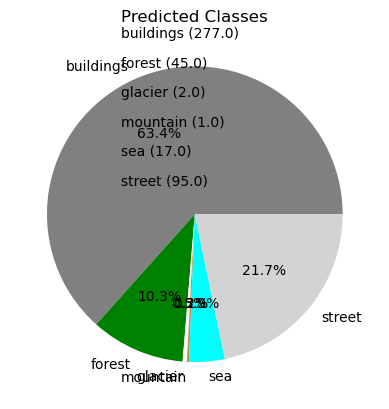

In [8]:
# Set the mask variable to determine if mask should be applied or not
mask = True
test_folder = r'E:\CNN4_Masked Image\seg_test\seg_test\buildings'

# Get the name of the test folder
test_folder_name = os.path.basename(test_folder)

# Set the output folder name
if mask:
    output_folder = 'Mask_results'
else:
    output_folder = 'noMask_results'

folder_names = test_folder.split("/")[-2:]
if len(folder_names) >= 2:
    output_folder_name = f"{output_folder}_{folder_names[0]}_{folder_names[1]}"
else:
    output_folder_name = f"{output_folder}_{test_folder_name}"

output_folder = os.path.join(os.path.dirname(output_folder), output_folder_name)

valid_extensions = ['.jpg', '.jpeg', '.png']
filenames = [filename for filename in os.listdir(test_folder) if os.path.splitext(filename)[1].lower() in valid_extensions]

# Class labels
class_labels = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}
os.makedirs(output_folder, exist_ok=True)
for label in class_labels.values():
    os.makedirs(os.path.join(output_folder, label), exist_ok=True)

# Initialize predictions list
predictions = []

# Process each image in the test folder
for filename in filenames:
    img = cv2.imread(os.path.join(test_folder, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB color space

    # Apply mask if required
    if mask:
        # Create a circular mask of the same size as the image
        mask_array = np.zeros(img.shape[:2], dtype=np.uint8)
        center = (img.shape[1] // 2, img.shape[0] // 2)
        radius = min(center[0], center[1])
        cv2.circle(mask_array, center, radius, (255, 255, 255), -1)

        # Apply the mask to the image
        masked_image = cv2.bitwise_and(img, img, mask=mask_array)

        # Convert the masked image back to PIL Image
        masked_image = Image.fromarray(masked_image)
    else:
        # If mask is not required, use the original image
        masked_image = Image.fromarray(img)

    # Apply transformations to the masked image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    img = transform(masked_image)
    img = img.unsqueeze(0)

    # Make prediction using the model
    with torch.no_grad():
        output = model(img)
    prediction = torch.argmax(output, dim=1).item()
    predictions.append(prediction)

    # Create the output path
    class_label = class_labels[prediction]
    output_path = os.path.join(output_folder, class_label, filename)

    # Convert the masked image to BGR format before saving
    masked_image_bgr = cv2.cvtColor(np.array(masked_image), cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, masked_image_bgr)

# Save predictions to a CSV file
csv_file_path = os.path.join(output_folder, 'Predictions.csv')
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Filename', 'Predicted Class Label'])
    for i, filename in enumerate(filenames):
        writer.writerow([filename, class_labels[predictions[i]]])

# Calculate class counts
class_counts = np.zeros(6)
for prediction in predictions:
    class_counts[prediction] += 1

# Create a pie chart of the class distribution
labels = ['buildings','forest','glacier', 'mountain', 'sea', 'street']
colors = ['gray', 'green', 'snow', 'peru', 'aqua', 'lightgrey']

# Plot the pie chart with labels and percentage values
plt.pie(class_counts, labels=labels, autopct='%1.1f%%', colors=colors, textprops={'color': 'black'})

# Add count labels to the pie chart
for i, count in enumerate(class_counts):
    plt.text(-0.5, 1.2 - i * 0.2, f"{labels[i]} ({count})", color='black')

plt.title('Predicted Classes')
png_file_path = os.path.join(output_folder, 'Prediction.png')
plt.savefig(png_file_path)
plt.show()

## Inference 6 -  Both Mask and No Mask <br>
- Having a parent folder to hold these 2 options
- Parent folder being output_folder

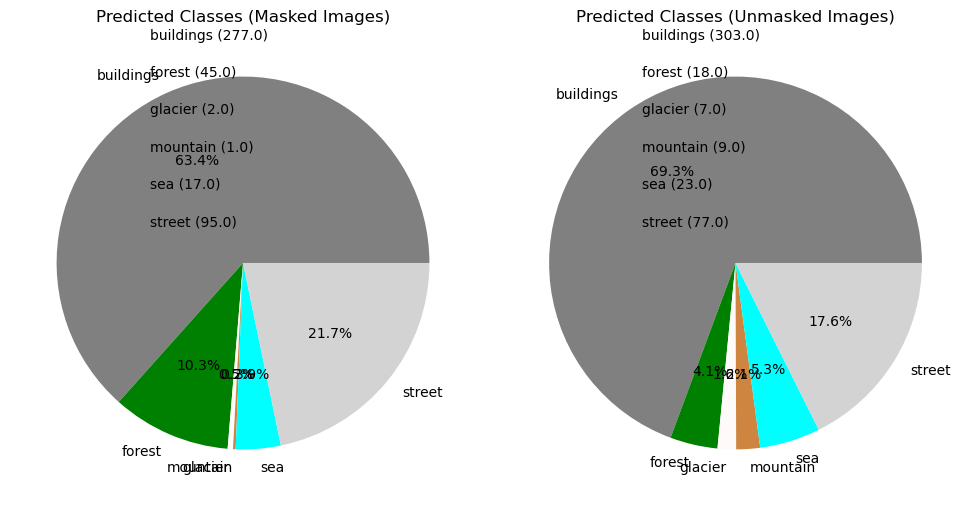

In [10]:
# Set the mask variable to determine if mask should be applied or not
mask = True
test_folder = r'E:\CNN4_Masked Image\seg_test\seg_test\buildings'

# Get the name of the test folder
test_folder_name = os.path.basename(test_folder)

# Set the output folder name
if mask:
    output_folder = 'Mask_results'
else:
    output_folder = 'noMask_results'

folder_names = test_folder.split("/")[-2:]
if len(folder_names) >= 2:
    output_folder_name = f"{output_folder}_{folder_names[0]}_{folder_names[1]}"
else:
    output_folder_name = f"{output_folder}_{test_folder_name}"

output_folder = os.path.join(os.path.dirname(output_folder), output_folder_name)

valid_extensions = ['.jpg', '.jpeg', '.png']
filenames = [filename for filename in os.listdir(test_folder) if os.path.splitext(filename)[1].lower() in valid_extensions]

# Define class labels
class_labels = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}

# Create the output folder if it does not exist
os.makedirs(output_folder, exist_ok=True)

# Create class-specific output directories for masked images
output_folder_mask = os.path.join(output_folder, 'Masked')
for label in class_labels.values():
    os.makedirs(os.path.join(output_folder_mask, label), exist_ok=True)

# Create class-specific output directories for unmasked images
output_folder_no_mask = os.path.join(output_folder, 'Unmasked')
for label in class_labels.values():
    os.makedirs(os.path.join(output_folder_no_mask, label), exist_ok=True)

# Define the circle mask parameters
mask_diameter = 224
mask_radius = mask_diameter // 2
mask_center = (mask_radius, mask_radius)

# Initialize predictions lists for masked and unmasked images
predictions_mask = []
predictions_no_mask = []

# Process each image in the test folder
for filename in filenames:
    # Read the image
    img = cv2.imread(os.path.join(test_folder, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB color space
    
    # Create a circular mask of the same size as the image
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    center = (img.shape[1] // 2, img.shape[0] // 2)
    radius = min(center[0], center[1])
    cv2.circle(mask, center, radius, (255, 255, 255), -1)

    # Apply the mask to the image
    masked_image = cv2.bitwise_and(img, img, mask=mask)

    # Convert the masked image back to PIL Image
    masked_image_pil = Image.fromarray(masked_image)

    # Apply transformations to the masked image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    img_mask = transform(masked_image_pil)
    img_mask = img_mask.unsqueeze(0)

    # Make prediction using the model for masked image
    with torch.no_grad():
        output_mask = model(img_mask)
    prediction_mask = torch.argmax(output_mask, dim=1).item()
    predictions_mask.append(prediction_mask)

    # Create the output path for masked image
    class_label_mask = class_labels[prediction_mask]
    output_path_mask = os.path.join(output_folder_mask, class_label_mask, filename)

    # Convert the masked image to BGR format before saving
    masked_image_bgr = cv2.cvtColor(np.array(masked_image_pil), cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path_mask, masked_image_bgr)

    # Apply transformations to the original image without mask
    img_no_mask = transform(Image.fromarray(img))
    img_no_mask = img_no_mask.unsqueeze(0)

    # Make prediction using the model for unmasked image
    with torch.no_grad():
        output_no_mask = model(img_no_mask)
    prediction_no_mask = torch.argmax(output_no_mask, dim=1).item()
    predictions_no_mask.append(prediction_no_mask)

    # Create the output path for unmasked image
    class_label_no_mask = class_labels[prediction_no_mask]
    output_path_no_mask = os.path.join(output_folder_no_mask, class_label_no_mask, filename)

    # Convert the original image to BGR format before saving
    img_no_mask_bgr = cv2.cvtColor(np.array(Image.fromarray(img)), cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path_no_mask, img_no_mask_bgr)

# Save predictions for masked images to a CSV file
csv_file_path_mask = os.path.join(output_folder_mask, 'Predictions.csv')
with open(csv_file_path_mask, 'w', newline='') as csvfile:
    writer_mask = csv.writer(csvfile)
    writer_mask.writerow(['Filename', 'Predicted Class Label'])
    for i, filename in enumerate(filenames):
        writer_mask.writerow([filename, class_labels[predictions_mask[i]]])

# Save predictions for unmasked images to a CSV file
csv_file_path_no_mask = os.path.join(output_folder_no_mask, 'Predictions.csv')
with open(csv_file_path_no_mask, 'w', newline='') as csvfile:
    writer_no_mask = csv.writer(csvfile)
    writer_no_mask.writerow(['Filename', 'Predicted Class Label'])
    for i, filename in enumerate(filenames):
        writer_no_mask.writerow([filename, class_labels[predictions_no_mask[i]]])

# Calculate class counts for masked images
class_counts_mask = np.zeros(6)
for prediction in predictions_mask:
    class_counts_mask[prediction] += 1

# Calculate class counts for unmasked images
class_counts_no_mask = np.zeros(6)
for prediction in predictions_no_mask:
    class_counts_no_mask[prediction] += 1

# Create a pie chart of the class distribution for masked images
labels = ['buildings','forest','glacier', 'mountain', 'sea', 'street']
colors = ['gray', 'green', 'snow', 'peru', 'aqua', 'lightgrey']


plt.figure(figsize=(10, 5))

plt.subplot(121)
# Plot the pie chart with labels and percentage values for masked images
plt.pie(class_counts_mask, labels=labels, autopct='%1.1f%%', colors=colors, textprops={'color': 'black'})
plt.title('Predicted Classes (Masked Images)')

# Add count labels to the pie chart for masked images
for i, count in enumerate(class_counts_mask):
    plt.text(-0.5, 1.2 - i * 0.2, f"{labels[i]} ({count})", color='black')

# Create a pie chart of the class distribution for unmasked images
plt.subplot(122)
# Plot the pie chart with labels and percentage values for unmasked images
plt.pie(class_counts_no_mask, labels=labels, autopct='%1.1f%%', colors=colors, textprops={'color': 'black'})
plt.title('Predicted Classes (Unmasked Images)')

# Add count labels to the pie chart for unmasked images
for i, count in enumerate(class_counts_no_mask):
    plt.text(-0.5, 1.2 - i * 0.2, f"{labels[i]} ({count})", color='black')

plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'Prediction.png'))
plt.show()

# BAR PLOT 

For Mask and Non Mask OPTIONS <br>
- Can choose to mask or without mask with the bool value mask = True

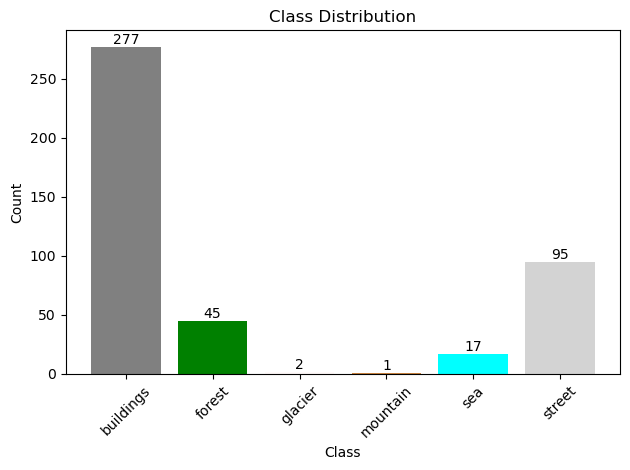

In [14]:
# Set the mask variable to determine if mask should be applied or not
mask = True
test_folder = r'E:\CNN4_Masked Image\seg_test\seg_test\buildings'

# Get the name of the test folder
test_folder_name = os.path.basename(test_folder)

# Set the output folder name
if mask:
    output_folder = 'Mask_results'
else:
    output_folder = 'noMask_results'

folder_names = test_folder.split("/")[-2:]
if len(folder_names) >= 2:
    output_folder_name = f"{output_folder}_{folder_names[0]}_{folder_names[1]}"
else:
    output_folder_name = f"{output_folder}_{test_folder_name}"

output_folder = os.path.join(os.path.dirname(output_folder), output_folder_name)

valid_extensions = ['.jpg', '.jpeg', '.png']
filenames = [filename for filename in os.listdir(test_folder) if os.path.splitext(filename)[1].lower() in valid_extensions]

# Class labels
class_labels = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}
os.makedirs(output_folder, exist_ok=True)
for label in class_labels.values():
    os.makedirs(os.path.join(output_folder, label), exist_ok=True)

# Initialize predictions list
predictions = []

# Process each image in the test folder
for filename in filenames:
    img = cv2.imread(os.path.join(test_folder, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB color space

    # Apply mask if required
    if mask:
        # Create a circular mask of the same size as the image
        mask_array = np.zeros(img.shape[:2], dtype=np.uint8)
        center = (img.shape[1] // 2, img.shape[0] // 2)
        radius = min(center[0], center[1])
        cv2.circle(mask_array, center, radius, (255, 255, 255), -1)

        # Apply the mask to the image
        masked_image = cv2.bitwise_and(img, img, mask=mask_array)

        # Convert the masked image back to PIL Image
        masked_image = Image.fromarray(masked_image)
    else:
        # If mask is not required, use the original image
        masked_image = Image.fromarray(img)

    # Apply transformations to the masked image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    img = transform(masked_image)
    img = img.unsqueeze(0)

    # Make prediction using the model
    with torch.no_grad():
        output = model(img)
    prediction = torch.argmax(output, dim=1).item()
    predictions.append(prediction)

    # Create the output path
    class_label = class_labels[prediction]
    output_path = os.path.join(output_folder, class_label, filename)

    # Convert the masked image to BGR format before saving
    masked_image_bgr = cv2.cvtColor(np.array(masked_image), cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, masked_image_bgr)

# Save predictions to a CSV file
csv_file_path = os.path.join(output_folder, 'Predictions.csv')
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Filename', 'Predicted Class Label'])
    for i, filename in enumerate(filenames):
        writer.writerow([filename, class_labels[predictions[i]]])

# Calculate class counts
class_counts = np.zeros(6)
for prediction in predictions:
    class_counts[prediction] += 1

# Create a bar plot of the class distribution
labels = ['buildings','forest','glacier', 'mountain', 'sea', 'street']
colors = ['gray', 'green', 'snow', 'peru', 'aqua', 'lightgrey']

plt.bar(labels, class_counts, color=colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')

# Add count labels to the bar plot
for i, count in enumerate(class_counts):
    plt.text(i, count, str(int(count)), ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## For Both Mask and No Mask <br>
- Having a parent folder to hold these 2 options
- Parent folder being output_folder

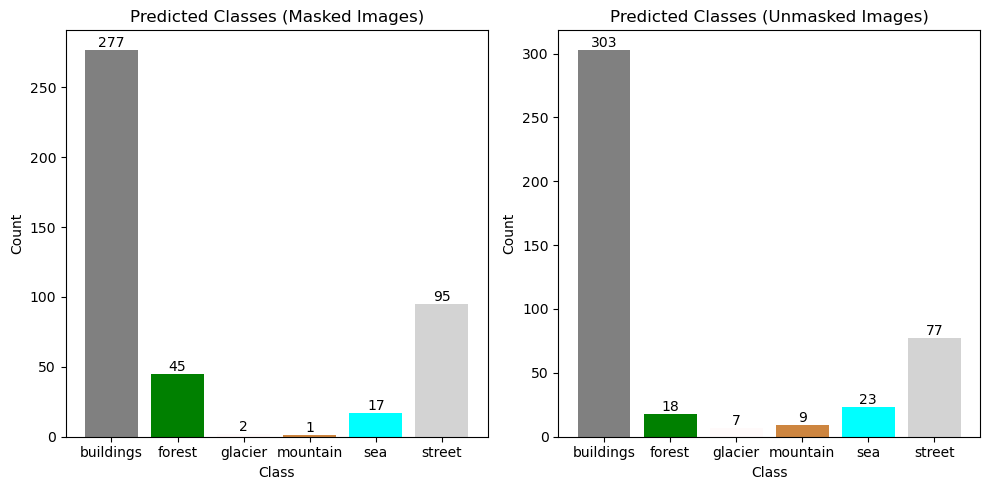

In [16]:
'''
                                            BAR CHART
- Before running the cell, make sure the "test_folder" is the right folder that has the images
that is being tested
'''
test_folder = r'E:\CNN4_Masked Image\seg_test\seg_test\buildings'

# Get the name of the test folder
test_folder_name = os.path.basename(test_folder)

# Set the output folder name
if mask:
    output_folder = 'Mask_results'
else:
    output_folder = 'noMask_results'

folder_names = test_folder.split("/")[-2:]
if len(folder_names) >= 2:
    output_folder_name = f"{output_folder}_{folder_names[0]}_{folder_names[1]}"
else:
    output_folder_name = f"{output_folder}_{test_folder_name}"

output_folder = os.path.join(os.path.dirname(output_folder), output_folder_name)

valid_extensions = ['.jpg', '.jpeg', '.png']
filenames = [filename for filename in os.listdir(test_folder) if os.path.splitext(filename)[1].lower() in valid_extensions]

# Define class labels
class_labels = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}

# Create the output folder if it does not exist
os.makedirs(output_folder, exist_ok=True)

# Create class-specific output directories for masked images
output_folder_mask = os.path.join(output_folder, 'Masked')
for label in class_labels.values():
    os.makedirs(os.path.join(output_folder_mask, label), exist_ok=True)

# Create class-specific output directories for unmasked images
output_folder_no_mask = os.path.join(output_folder, 'Unmasked')
for label in class_labels.values():
    os.makedirs(os.path.join(output_folder_no_mask, label), exist_ok=True)

# Define the circle mask parameters
mask_diameter = 224
mask_radius = mask_diameter // 2
mask_center = (mask_radius, mask_radius)

# Initialize predictions lists for masked and unmasked images
predictions_mask = []
predictions_no_mask = []

# Process each image in the test folder
for filename in filenames:
    # Read the image
    img = cv2.imread(os.path.join(test_folder, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB color space
    
    # Create a circular mask of the same size as the image
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    center = (img.shape[1] // 2, img.shape[0] // 2)
    radius = min(center[0], center[1])
    cv2.circle(mask, center, radius, (255, 255, 255), -1)

    # Apply the mask to the image
    masked_image = cv2.bitwise_and(img, img, mask=mask)

    # Convert the masked image back to PIL Image
    masked_image_pil = Image.fromarray(masked_image)

    # Apply transformations to the masked image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    img_mask = transform(masked_image_pil)
    img_mask = img_mask.unsqueeze(0)

    # Make prediction using the model for masked image
    with torch.no_grad():
        output_mask = model(img_mask)
    prediction_mask = torch.argmax(output_mask, dim=1).item()
    predictions_mask.append(prediction_mask)

    # Create the output path for masked image
    class_label_mask = class_labels[prediction_mask]
    output_path_mask = os.path.join(output_folder_mask, class_label_mask, filename)

    # Convert the masked image to BGR format before saving
    masked_image_bgr = cv2.cvtColor(np.array(masked_image_pil), cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path_mask, masked_image_bgr)

    # Apply transformations to the original image without mask
    img_no_mask = transform(Image.fromarray(img))
    img_no_mask = img_no_mask.unsqueeze(0)

    # Make prediction using the model for unmasked image
    with torch.no_grad():
        output_no_mask = model(img_no_mask)
    prediction_no_mask = torch.argmax(output_no_mask, dim=1).item()
    predictions_no_mask.append(prediction_no_mask)

    # Create the output path for unmasked image
    class_label_no_mask = class_labels[prediction_no_mask]
    output_path_no_mask = os.path.join(output_folder_no_mask, class_label_no_mask, filename)

    # Convert the original image to BGR format before saving
    img_no_mask_bgr = cv2.cvtColor(np.array(Image.fromarray(img)), cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path_no_mask, img_no_mask_bgr)

# Save predictions for masked images to a CSV file
csv_file_path_mask = os.path.join(output_folder_mask, 'Predictions.csv')
with open(csv_file_path_mask, 'w', newline='') as csvfile:
    writer_mask = csv.writer(csvfile)
    writer_mask.writerow(['Filename', 'Predicted Class Label'])
    for i, filename in enumerate(filenames):
        writer_mask.writerow([filename, class_labels[predictions_mask[i]]])

# Save predictions for unmasked images to a CSV file
csv_file_path_no_mask = os.path.join(output_folder_no_mask, 'Predictions.csv')
with open(csv_file_path_no_mask, 'w', newline='') as csvfile:
    writer_no_mask = csv.writer(csvfile)
    writer_no_mask.writerow(['Filename', 'Predicted Class Label'])
    for i, filename in enumerate(filenames):
        writer_no_mask.writerow([filename, class_labels[predictions_no_mask[i]]])

# Calculate class counts for masked images
class_counts_mask = np.zeros(6)
for prediction in predictions_mask:
    class_counts_mask[prediction] += 1

# Calculate class counts for unmasked images
class_counts_no_mask = np.zeros(6)
for prediction in predictions_no_mask:
    class_counts_no_mask[prediction] += 1

# Create a bar plot of the class distribution for masked images
labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
colors = ['gray', 'green', 'snow', 'peru', 'aqua', 'lightgrey']

plt.figure(figsize=(10, 5))

plt.subplot(121)
# Plot the bar chart with labels and counts for masked images
plt.bar(labels, class_counts_mask, color=colors)
plt.title('Predicted Classes (Masked Images)')
plt.xlabel('Class')
plt.ylabel('Count')

# Add count labels to the bar chart for masked images
for i, count in enumerate(class_counts_mask):
    plt.text(i, count, str(int(count)), ha='center', va='bottom')

# Create a bar plot of the class distribution for unmasked images
plt.subplot(122)
# Plot the bar chart with labels and counts for unmasked images
plt.bar(labels, class_counts_no_mask, color=colors)
plt.title('Predicted Classes (Unmasked Images)')
plt.xlabel('Class')
plt.ylabel('Count')

# Add count labels to the bar chart for unmasked images
for i, count in enumerate(class_counts_no_mask):
    plt.text(i, count, str(int(count)), ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'Prediction.png'))
plt.show()